# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv


Bad key "text.kerning_factor" on line 4 in
C:\Users\mypha\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [5]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [28]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [16]:
# Getting the data from the top 10 expensive neighbourhoods
top_neighbourhoods = to_data.groupby('neighbourhood').mean()
top_neighbourhoods = top_neighbourhoods.sort_values(by='average_house_value',ascending=False).head(10).reset_index()

# Calculate the mean number of dwelling types units per year
df_dwelling_average = to_data.groupby([to_data.index,'neighbourhood']).mean().reset_index()

# Calculate the average monthly shelter costs for owned and rented dwellings
df_costs = to_data[["shelter_costs_owned", "shelter_costs_rented"]].groupby(to_data.index).mean()

In [43]:
df_dwelling_types = to_data.groupby(to_data.index).sum()
df_dwelling_types = df_dwelling_types.iloc[:,0:8]

### Panel Visualization Functions

In [44]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
   
    mean_neighbourhoods = to_data.groupby('neighbourhood').mean().reset_index()
    df_all_neighbourhoods = pd.merge(df_neighbourhood_locations,mean_neighbourhoods,on='neighbourhood',how='inner')
    
    px.set_mapbox_access_token(map_box_api)
    
    neighbourhood_map = px.scatter_mapbox(
    df_all_neighbourhoods,
    lat="lat",
    lon="lon",
    size='average_house_value',
    color='average_house_value',
    title='Average House Value in Toronto',
    size_max=15,
    zoom=9
    )
    
    plotly_panel = pn.pane.Plotly(neighbourhood_map)
    plotly_panel._updates = True
    return plotly_panel

def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    
    """
    
    fig_dwelling_types = plt.figure() 
    plot_dwelling_types = data.plot.bar(color=color)
    plot_dwelling_types.set_xlabel(xlabel)
    plot_dwelling_types.set_ylabel(ylabel)
    plot_dwelling_types.set_title(title)
    
    plt.close(fig_dwelling_types)
    return pn.pane.Matplotlib(fig_dwelling_types, tight=True)
    
def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    fig_dwelling_types = plt.figure() 
    plot_dwelling_types = data.plot(color=color)
    plot_dwelling_types.set_xlabel(xlabel)
    plot_dwelling_types.set_ylabel(ylabel)
    plot_dwelling_types.set_title(title)
    plt.xticks(rotation=90)  
    
    plt.close(fig_dwelling_types)
    return pn.pane.Matplotlib(fig_dwelling_types, tight=True)

def average_house_value():
    """Average house values per year."""
    
    average_house_value = to_data["average_house_value"].groupby(to_data.index).mean()
    
    fig_house_value = plt.figure()
    plot_house_value = average_house_value.plot(color='blue')
    plot_house_value.set_xlabel('Year')
    plot_house_value.set_ylabel('Average House Value')
    plot_house_value.set_title('Averag House Value Per Year')
    plt.xticks(rotation=90)  
    
    plt.close(fig_house_value)
    return pn.pane.Matplotlib(fig_house_value, tight=True)

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    new_df = to_data.reset_index()
    new_df = new_df[["year","average_house_value","neighbourhood"]]
    df_mean_house = new_df.groupby(['neighbourhood','year']).mean()
    df_mean_house.reset_index(inplace=True)
    
    average_value_nieghbourhood = df_mean_house.hvplot.line(
        'year',
        'average_house_value',
        xlabel = "Year", 
        ylabel = "Average House Value",
        groupby='neighbourhood',
    )
    
    return average_value_nieghbourhood
    
def number_dwelling_types():
    """Number of dwelling types per year"""
    
    df_dwelling_average = to_data.groupby([to_data.index,'neighbourhood']).mean().reset_index()
    dwelling = df_dwelling_average.hvplot.bar(
        'year',
        ['single_detached_house',
         'apartment_five_storeys_plus',
         'movable_dwelling',
         'semi_detached_house',
         'row_house',
         'duplex',
         'apartment_five_storeys_less',
         'other_house'],
        xlabel = "Year", 
        ylabel = "",
        groupby='neighbourhood',
        height=400,
        rot=90
    )
    
    return dwelling

def average_house_value_snapshot(): # what is the different with the functions above???
    """Average house value for all Toronto's neighbourhoods per year."""

    return to_data['average_house_value'].groupby(to_data.index).mean()

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    top_neighbourhoods = to_data.groupby('neighbourhood').mean()
    top_neighbourhoods = top_neighbourhoods.sort_values(by='average_house_value',ascending=False).head(10).reset_index()
    expensive = top_neighbourhoods.hvplot.bar(
        'neighbourhood',
        'average_house_value',
        xlabel = "Neighbourhood", 
        ylabel = "Average House Value",
        title='Top 10 Expensive Neighbourhoods in Toronto',
        height=400,
        rot=90,
    )
    
    return expensive

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    # Optional

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [71]:
## Create a Title for the Dashboard
title = pn.pane.Markdown(
"""
# Real Estate Analysis of Toronto
""",
    width=750,
)

# Define a welcome text
welcome = pn.pane.Markdown(
"""
This is a dashboard that correspond to a real estate analysis for the Toronto Area from 2001 to 2016.
Please navigate using the tabs to explore the neighborhoods costs analysis.
""")

# Create a tab layout for the dashboard
tabs = pn.Tabs(

    ("Welcome", pn.Column(welcome, neighbourhood_map())),
    ("Dwelling Types Analysis", pn.Column(create_bar_chart(df_dwelling_types.loc[2001],"Dwelling Types on 2001","Dwelling Types","Count",'red'),
                                         create_bar_chart(df_dwelling_types.loc[2006],"Dwelling Types on 2006", "Dwelling Types","Count","Blue"),
                                         create_bar_chart(df_dwelling_types.loc[2011],"Dwelling Types on 2011", "Dwelling Types","Count","green"),
                                         create_bar_chart(df_dwelling_types.loc[2016],"Dwelling Types on 2016", "Dwelling Types","Count","purple"))),
    ("Average Monthly Shelter Costs", pn.Column(create_line_chart(df_dwelling_types.loc[2001],"Dwelling Types on 2001","Dwelling Types","Count",'red'),
                                               create_line_chart(df_dwelling_types.loc[2006],"Dwelling Types on 2006","Dwelling Types","Count",'blue'),
                                               create_line_chart(df_dwelling_types.loc[2011],"Dwelling Types on 2011","Dwelling Types","Count",'pink'),
                                               create_line_chart(df_dwelling_types.loc[2016],"Dwelling Types on 2016","Dwelling Types","Count",'yellow'))),
    ("House Analysis", pn.Column(average_house_value())),
    ("Neighbourhood Analysis", pn.Column(average_value_by_neighbourhood(),
                                        number_dwelling_types(),
                                        top_most_expensive_neighbourhoods))
)

# Create the main dashboard
dashboard = pn.Column(pn.Row(title), tabs, width=1000)

## Serve the Panel Dashboard

Column(width=1000)
    [0] Row
        [0] Markdown(str, width=750)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
            [3] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
            [3] Matplotlib(Figure, tight=True)
        [3] Column
            [0] Matplotlib(Figure, tight=True)
        [4] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
            [2] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Bars, name='interactive04915')
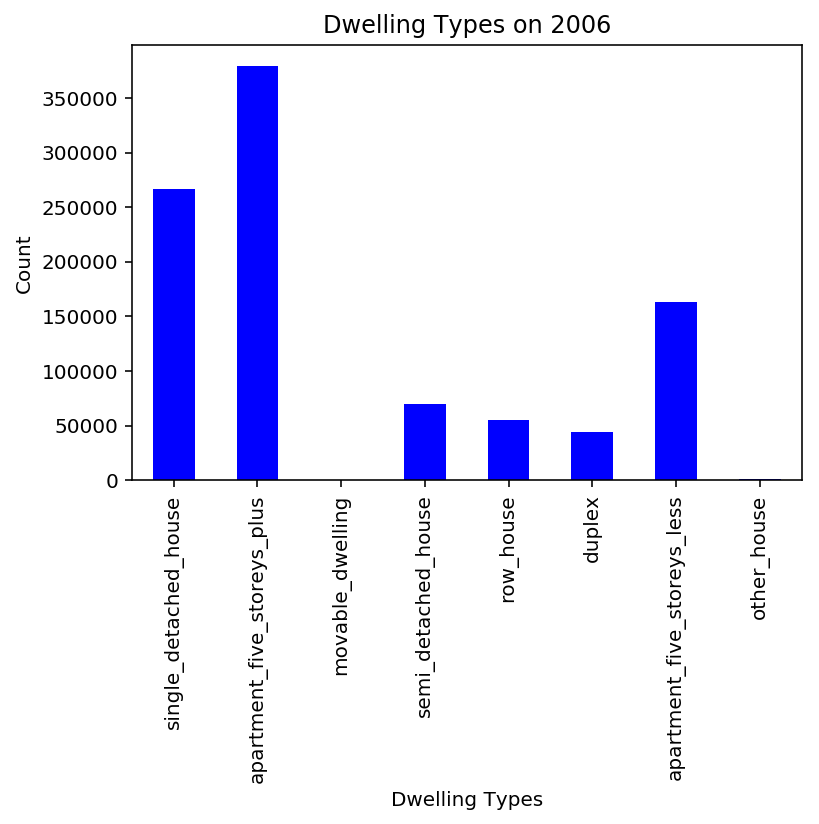
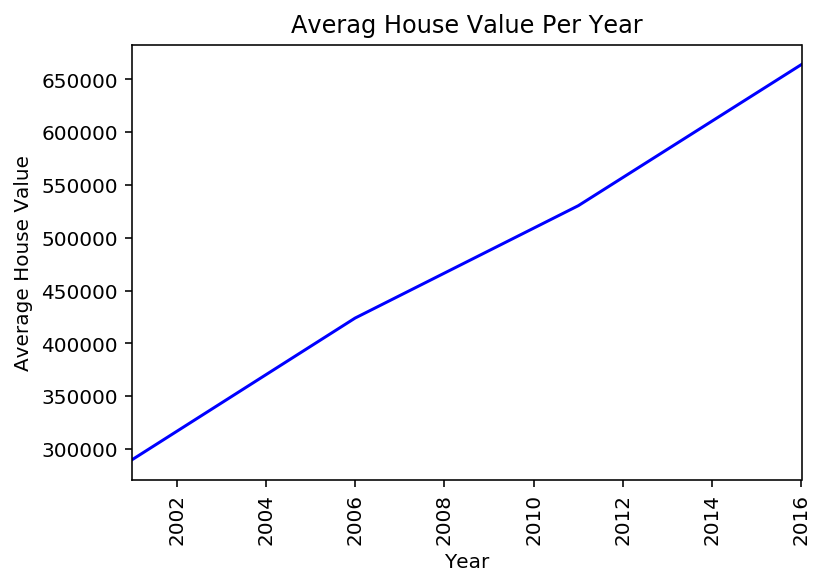
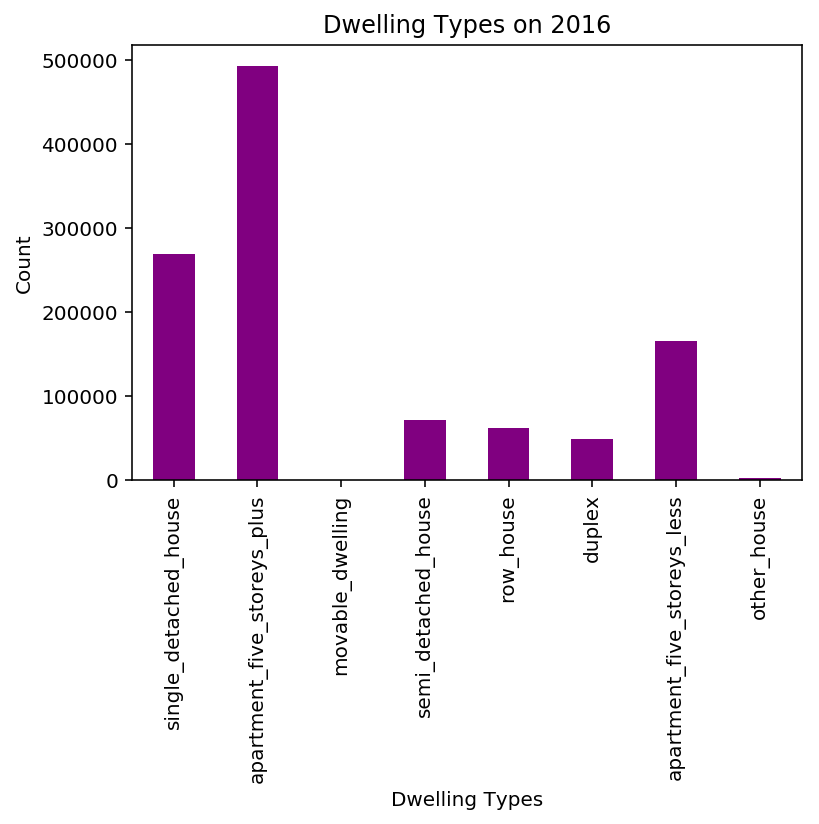
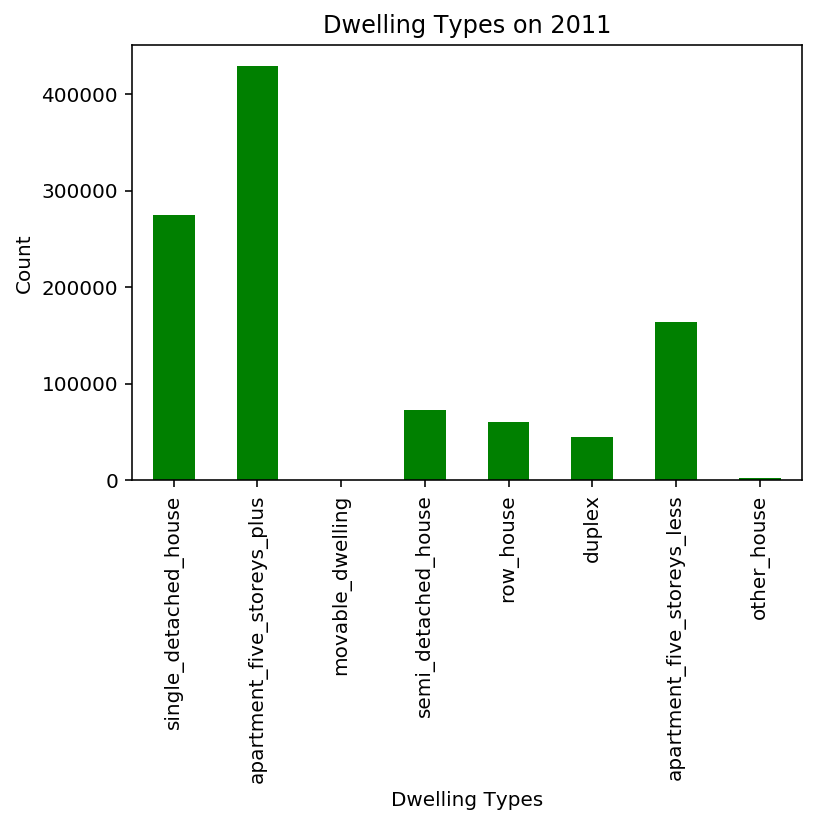
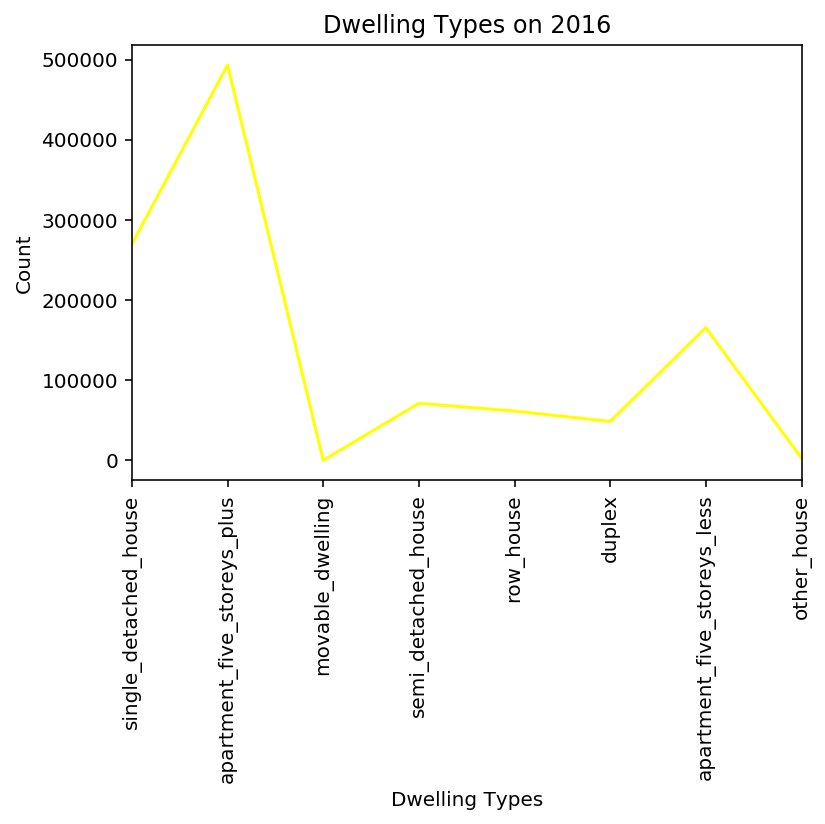
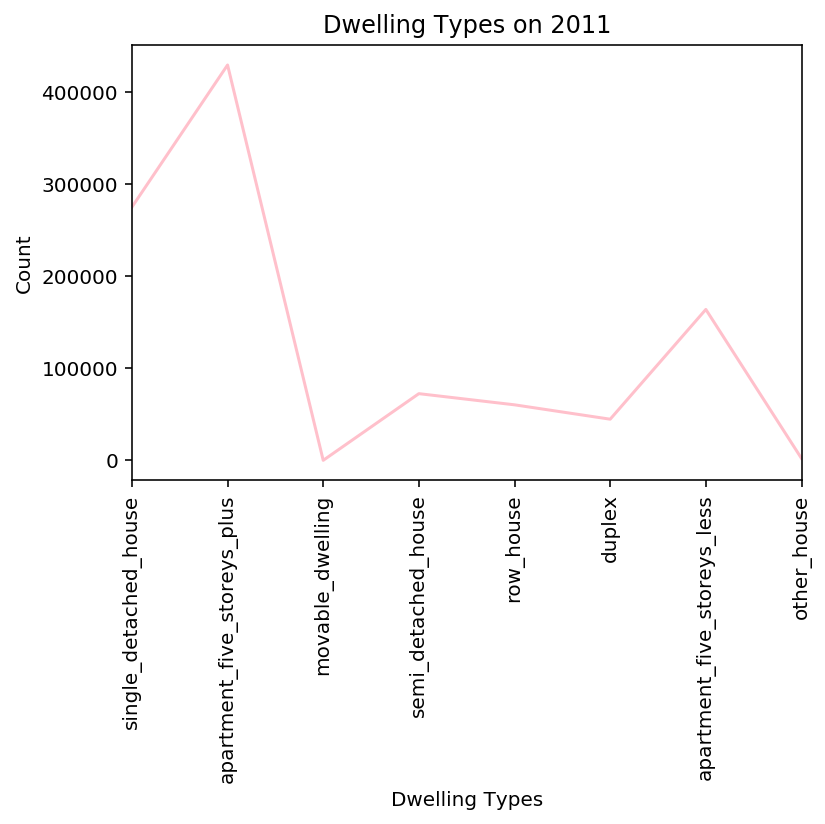
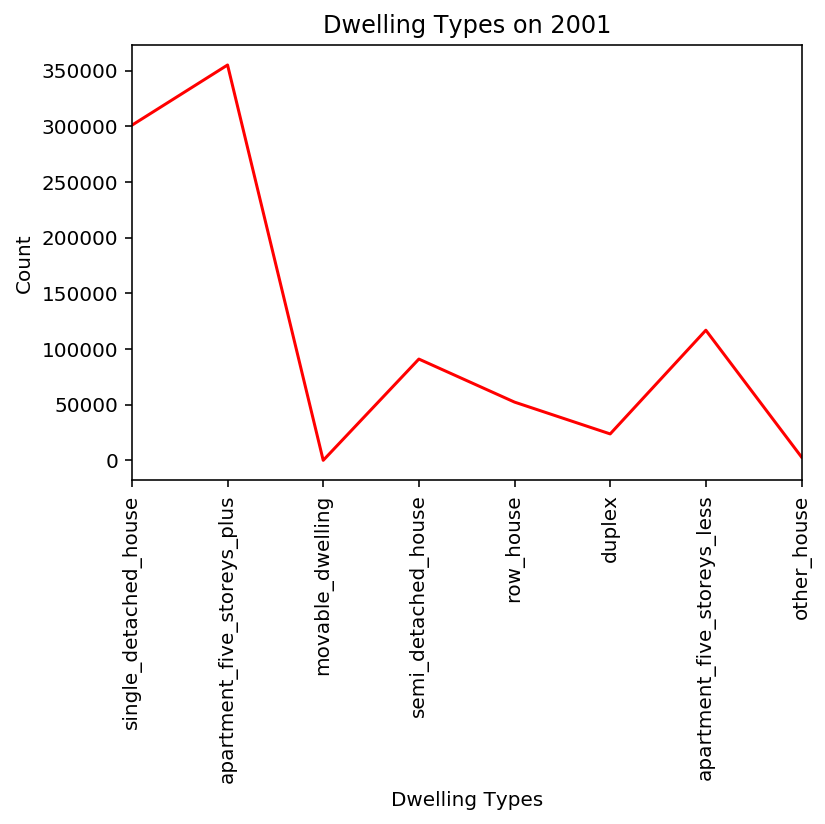
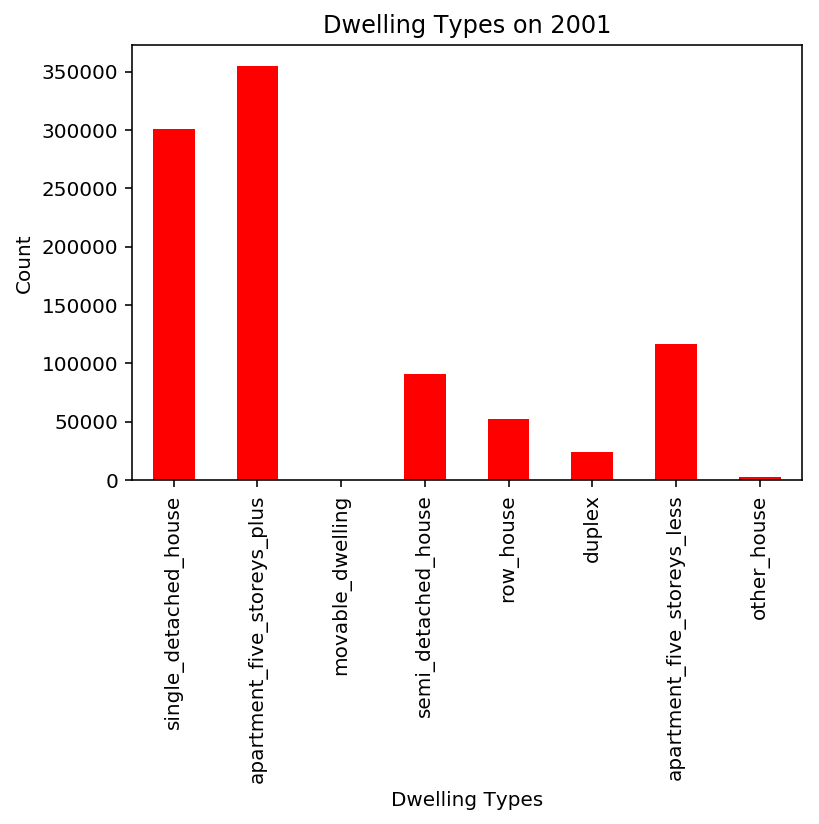
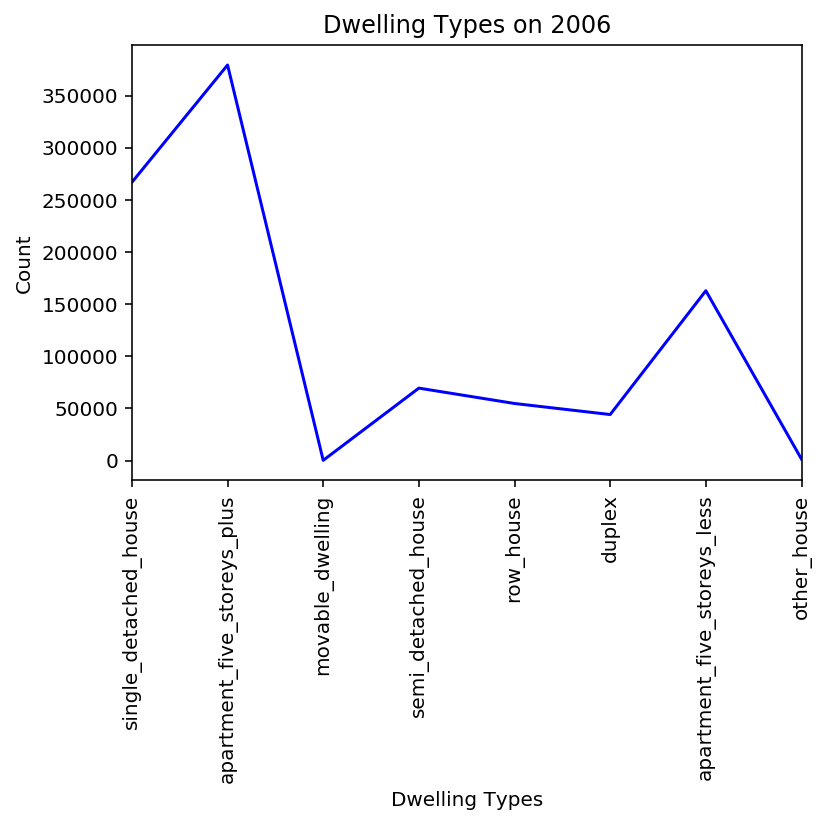

In [72]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
# neighbourhood_map().show()

In [ ]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [ ]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [ ]:
# average_house_value()

In [ ]:
# average_value_by_neighbourhood()

In [ ]:
# number_dwelling_types()

In [ ]:
# average_house_value_snapshot()

In [ ]:
# top_most_expensive_neighbourhoods()

In [ ]:
# sunburts_cost_analysis()